In [1]:
# GPU Reset if needed

from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
# Disable CUDA for TF 2.x

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [3]:
# Mount Google Drive if running on Google Colab

# from google.colab import drive
import os

# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Colab Notebooks/hf/')
print(os.getcwd())

D:\NLP_Last\files\UPLOAD\Transformers_HF


In [4]:
# List current directory

#!dir

In [5]:
# Remove current logs

#!rm -rf logs

In [6]:
# Import Tensorflow and related libraries

import tensorflow

print("Tensorflow precision mode : " + tensorflow.keras.backend.floatx())

# # Set Tensorflow precision mode to 'float16' to speedup with newer GPU
# tensorflow.keras.backend.set_floatx('float32')

# print("Tensorflow precision mode (after change) : " + tensorflow.keras.backend.floatx())

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Input

from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder

print("TensorFlow version : " + tensorflow.__version__)

import numpy as np
print("Numpy version : " + np.version.version)

import pandas as pd
print("Pandas version : " + pd.__version__)

Tensorflow precision mode : float32
TensorFlow version : 2.9.0-dev20220102
Numpy version : 1.22.0
Pandas version : 1.3.4


In [7]:
# Display available GPUs

physical_devices = tensorflow.config.list_physical_devices(('GPU'))
for gpu in physical_devices:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [8]:
# Show GPU status

!nvidia-smi

Fri Feb 25 09:13:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0D:00.0  On |                  N/A |
|  0%   51C    P2    42W / 170W |   1909MiB / 12288MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# Fix for "CUDA_ERROR_ILLEGAL_ADDRESS"

# Ref : https://github.com/tensorflow/tensorflow/issues/40814#issuecomment-663838196

os.environ['TF_CUDNN_DETERMINISTIC']='1'

In [10]:
# Enable Memory Growth

try:
    if physical_devices != []:
        tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
        physical_devices[0]
except:
    print("error")      

In [11]:
# Global Parameters

author_list = ['Charles Dickens','Jane Austen','Sir Arthur Conan Doyle','George Eliot','Jules Verne']
seed_number = 18
dataset_file  = "dataset.csv"
validation_dataset_file  = "validation_dataset.csv"

# For 3 GB VRAM : 
# batch_size = 2 when seq_length = 128, otherwise "out of memory"
# Typical single epoch runtime = 20 mins

batch_size = 32 # number of batch size
epochs = 5 # number of maximum epochs to run
seq_length = 100#300 # BERT Model sequence length
dropout_value = 0.1 # Dropout layer value for Model
init_lr = 3e-5 # Initial learning rate

In [12]:
# Reading validation data (from seperate books)

validation_data = pd.read_csv(validation_dataset_file, usecols = ['author','text'])
X_val_2 = validation_data.text
y_val_2 = validation_data.author

In [13]:
# Reading training/test/validation data

data = pd.read_csv(dataset_file, usecols = ['author','text'])

In [14]:
#data.sample(5)

In [15]:
from sklearn.model_selection import train_test_split

# Train, Test, Validation Spit ratios 60%, 20%, 20% 

X_train, X_val, y_train, y_val = train_test_split(data["text"], data["author"], test_size=0.2, random_state=2000)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=seed_number) # 0.25 x 0.8 = 0.2

In [16]:
print("Number of training data:",len(X_train))
print("Number of test data:",len(X_test))
print("Number of validation data (from same books):",len(X_val))
print("Number of validation data (from seperate books):",len(X_val_2))
print("Number of max characters in training dataset:",max(X_train.apply(len)))

Number of training data: 15000
Number of test data: 5000
Number of validation data (from same books): 5000
Number of validation data (from seperate books): 4000
Number of max characters in training dataset: 370


In [17]:
# Encoding label text to integeres

label_tokenizer = LabelEncoder()
label_tokenizer.fit(author_list)
label_index = label_tokenizer.classes_

y_train_sequences = np.array(label_tokenizer.transform(y_train))
y_test_sequences = np.array(label_tokenizer.transform(y_test))
y_val_sequences = np.array(label_tokenizer.transform(y_val))
y_val_sequences_2 = np.array(label_tokenizer.transform(y_val_2))

In [18]:
label_index

array(['Charles Dickens', 'George Eliot', 'Jane Austen', 'Jules Verne',
       'Sir Arthur Conan Doyle'], dtype='<U22')

### XLNet Model

In [19]:
# !pip install transformers==4.6.0

In [20]:
from transformers import XLNetTokenizerFast, TFXLNetModel

In [21]:
#######################################
### --------- Setup  ---------- ###

# Ref: https://huggingface.co/transformers/model_doc/xlnet.html#tfxlnetmodel


# Name of the  model to use
model_name = 'xlnet-base-cased'

# Max length of tokens
max_length = seq_length #100

# Load transformers config and set output_hidden_states to False
# config = BertConfig.from_pretrained(model_name)
# config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = XLNetTokenizerFast.from_pretrained(model_name)#BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFXLNetModel.from_pretrained(model_name) #TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [22]:
#######################################
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
xlnet = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')

inputs = {'input_ids': input_ids}

# Load the Transformers xlnet model as a layer in a Keras model
xlnet_model = xlnet(inputs)[0]
dropout = Dropout(dropout_value, name='pooled_output')#Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(xlnet_model, training=False)

In [23]:
def X_tokenizer(X_original):
    X_original = tokenizer(
    text=X_original.to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length', 
   # pad_to_max_length="right",
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

    X_original={'input_ids': X_original['input_ids']}
    return X_original
    

In [24]:
X_train = X_tokenizer(X_train)
X_test = X_tokenizer(X_test)
X_val = X_tokenizer(X_val)
X_val_2 = X_tokenizer(X_val_2)

In [25]:
X_train

{'input_ids': <tf.Tensor: shape=(15000, 100), dtype=int32, numpy=
 array([[    5,     5,     5, ...,   124,     4,     3],
        [    5,     5,     5, ...,    43,     4,     3],
        [    5,     5,     5, ..., 14118,     4,     3],
        ...,
        [    5,     5,     5, ...,   132,     4,     3],
        [    5,     5,     5, ...,   193,     4,     3],
        [    5,     5,     5, ...,  9670,     4,     3]])>}

In [26]:
#del model

In [27]:
# define new model

flatten = tensorflow.keras.layers.Flatten()(pooled_output) 
model_output = tensorflow.keras.layers.Dense(5, activation='softmax')(flatten)

model = tensorflow.keras.Model(inputs, model_output)

model._name = "nlp_XLNet_" + str(seed_number) 
model.summary()

Model: "nlp_XLNet_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 100)]             0         
                                                                 
 transformer (TFXLNetMainLay  TFXLNetModelOutput(last_  116718336
 er)                         hidden_state=(None, 100,            
                              768),                              
                              mems=((100, None, 768),            
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),       

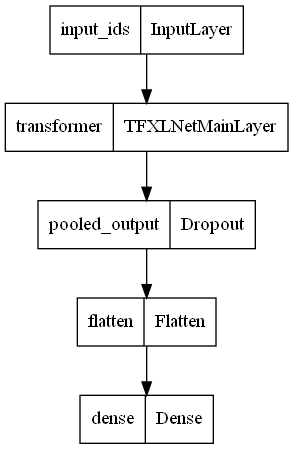

In [28]:
# Save the model as a png file
plot_model(model, to_file=model._name +'.png', show_layer_names=True)

In [29]:
# Show the trainable status of the layers

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_ids True
1 transformer True
2 pooled_output True
3 flatten True
4 dense True


In [30]:
# Define Optimizer

# steps_per_epoch = int(len(X_train)/batch_size) #tensorflow.data.experimental.cardinality(data_train).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)
# print(steps_per_epoch,num_train_steps,num_warmup_steps)

# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')

In [31]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

In [32]:
# Compile the model

model.compile(
    #optimizer=tensorflow.keras.optimizers.Adam(learning_rate=3e-5),
    #optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001),
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [33]:
# Tensorboard parameters

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
# Use best weights for the model

early_stopping_monitor = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

In [35]:
# Training the model
# callbacks are not used : early_stopping_monitor (to speed up), tensorboard_callback (has a bug with BERT)

history = model.fit(X_train, y_train_sequences, epochs=epochs, batch_size = batch_size, shuffle = True, callbacks=[], validation_data=(X_test , y_test_sequences ),)

Epoch 1/5
469/469 [==============================] - 267s 549ms/step - loss: 0.8188 - accuracy: 0.6929 - val_loss: 0.4586 - val_accuracy: 0.8464
Epoch 2/5
469/469 [==============================] - 253s 540ms/step - loss: 0.3074 - accuracy: 0.8889 - val_loss: 0.3735 - val_accuracy: 0.8792
Epoch 3/5
469/469 [==============================] - 252s 537ms/step - loss: 0.2020 - accuracy: 0.9285 - val_loss: 0.4594 - val_accuracy: 0.8672
Epoch 4/5
469/469 [==============================] - 256s 546ms/step - loss: 0.1455 - accuracy: 0.9470 - val_loss: 0.5006 - val_accuracy: 0.8762
Epoch 5/5
469/469 [==============================] - 253s 539ms/step - loss: 0.1105 - accuracy: 0.9591 - val_loss: 0.4478 - val_accuracy: 0.8896


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


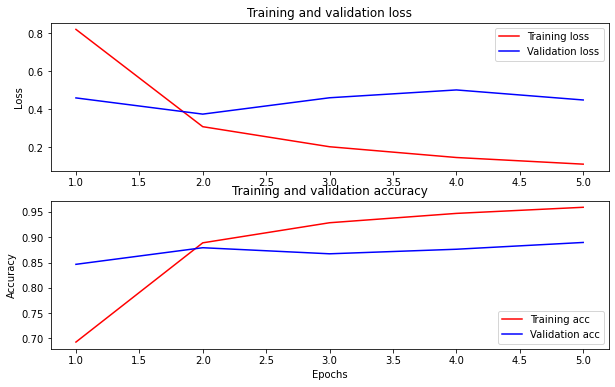

In [36]:
# Plot the accuracy and loss over time 
# Reusing sample code from : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

#print(loss)

epochs_number = range(1, (epochs) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs_number, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_number, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_number, acc, 'r', label='Training acc')
plt.plot(epochs_number, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [37]:
# Show tensorboard

# %load_ext tensorboard
# %tensorboard --logdir logs/fit
#%reload_ext tensorboard # just in case tensorboard didn't refresh

In [38]:
X_val_2

{'input_ids': <tf.Tensor: shape=(4000, 100), dtype=int32, numpy=
 array([[   5,    5,    5, ...,  889,    4,    3],
        [   5,    5,    5, ...,  150,    4,    3],
        [   5,    5,    5, ...,   90,    4,    3],
        ...,
        [   5,    5,    5, ..., 3968,    4,    3],
        [   5,    5,    5, ..., 1435,    4,    3],
        [   5,    5,    5, ..., 5340,    4,    3]])>}

In [39]:
X_test

{'input_ids': <tf.Tensor: shape=(5000, 100), dtype=int32, numpy=
 array([[    5,     5,     5, ...,    64,     4,     3],
        [    5,     5,     5, ...,  7792,     4,     3],
        [    5,     5,     5, ...,  2667,     4,     3],
        ...,
        [    5,     5,     5, ...,    76,     4,     3],
        [    5,     5,     5, ..., 28187,     4,     3],
        [    5,     5,     5, ...,    52,     4,     3]])>}

In [40]:
#model.predict([X_test])

In [41]:
# Function to generate accuracy report

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

def accuracy_report(X_val_seq,y_val_seq):
    # Calculate preditions for the validation dataset

    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    y_pred = model.predict([X_val_seq])
    y_pred = np.argmax(y_pred, axis=1)
    #len(y_pred)

    y_true= y_val_seq
    #len(y_true)

    # Convert the true and predicted labels into arrays
    true_categories = label_tokenizer.inverse_transform(y_true)
    predicted_categories = label_tokenizer.inverse_transform(y_pred)
    # print(predicted_categories)

    # Generate confusion matrix

    cnf_matrix = confusion_matrix(true_categories,predicted_categories,  normalize='pred')

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,display_labels=label_index)
    disp = disp.plot(cmap='Greens', xticks_rotation=45)
    plt.show()

    print("Accuracy for validation split: " ,accuracy_score(y_true, y_pred))
    print( "F1_score: " + str(f1_score(y_true, y_pred, average='micro')))

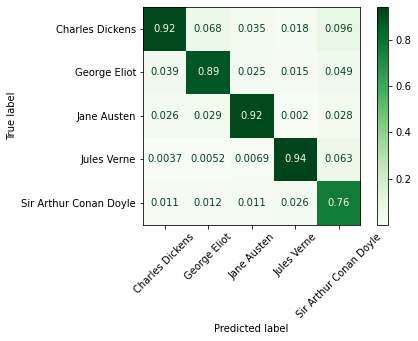

Accuracy for validation split:  0.8806
F1_score: 0.8806


In [42]:
# accuracy_report for same books

accuracy_report(X_val,y_val_sequences)

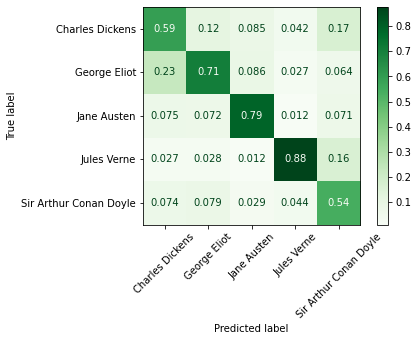

Accuracy for validation split:  0.67875
F1_score: 0.67875


In [43]:
# accuracy_report for seperate books

accuracy_report(X_val_2,y_val_sequences_2)

In [44]:
model.summary()

Model: "nlp_XLNet_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 100)]             0         
                                                                 
 transformer (TFXLNetMainLay  TFXLNetModelOutput(last_  116718336
 er)                         hidden_state=(None, 100,            
                              768),                              
                              mems=((100, None, 768),            
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),                  
                              (100, None, 768),       

In [45]:
# Saving final model for future use

#model.save("bert_5.h5", save_format='h5')
#tensorflow.keras.models.save_model(model,model._name)

In [46]:
#!tar czf bert_epoch5_adamw_compress.tar.gz bert_epoch5_adamw/

In [47]:
!nvidia-smi

Fri Feb 25 09:35:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0D:00.0  On |                  N/A |
| 81%   68C    P2   127W / 170W |  10717MiB / 12288MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
model.save(model._name, include_optimizer=False)

INFO:tensorflow:Assets written to: nlp_XLNet_18\assets


INFO:tensorflow:Assets written to: nlp_XLNet_18\assets


In [49]:
#!tar czf bert_no_optimizer.tar.gz bert_no_optimizer/

In [50]:
# Reloading model

#reloaded_model = tensorflow.saved_model.load("bert_no_optimizer")

In [51]:
# Comparing results of model in memory and reloaded model

#text_string = X_val.iloc[0]

In [52]:
# Correct result

#y_val.iloc[0]

In [53]:
#model_result = model(tensorflow.constant([text_string]))

In [54]:
#reloaded_model_result = reloaded_model(tensorflow.constant([text_string]))

In [55]:
# Result from model in memory

#label_index[np.argmax(model_result, axis=1)]

In [56]:
# Result from reloaded model

#label_index[np.argmax(reloaded_model_result, axis=1)]